In [1]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns
import funs_project as fp

# Optimisation

In [2]:
ACTORNAME = "Overijssel"

In [3]:
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)
outcomekeys = [outcome.name for outcome in dike_model.outcomes]

## Reading
The results from the optimization. The policies that are selected with the cure_policy_selection.

In [4]:
cases = fp.the_cases(ACTORNAME)

In [5]:
policies = fp.crude_policy_selection(ACTORNAME, 6)

In [6]:
policies = policies.sort_values(by="scenario")
policies

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,scenario
1,0,0,0,0,0,0,3,5,0,0,5,0,0,0.000000e+00,0.000000,4.774545e+07,1
21,0,0,0,0,0,0,1,5,0,0,2,0,0,1.396212e+07,0.003764,3.864763e+07,2
12,0,0,0,0,0,0,2,4,0,0,0,0,0,4.931441e+07,0.004930,9.699218e+06,2
10,0,0,0,0,0,0,3,9,0,0,5,0,0,0.000000e+00,0.000000,5.482076e+07,2
18,0,0,0,0,0,0,0,8,0,0,5,0,0,6.651750e+05,0.000557,5.278559e+07,2
22,0,0,0,0,0,0,2,4,0,0,6,0,0,0.000000e+00,0.000000,4.996887e+07,3
34,0,0,0,0,0,0,3,0,0,0,8,0,0,7.854216e+07,0.009674,4.846921e+07,4
44,0,0,0,0,0,0,3,0,0,0,7,0,0,1.419876e+08,0.017511,4.420352e+07,4
46,0,0,0,0,0,0,3,0,0,0,3,0,0,6.008769e+08,0.072203,3.039539e+07,4
40,0,0,0,0,0,0,3,0,0,0,2,0,0,9.028940e+08,0.106645,2.764582e+07,4


In [7]:
#policies.iloc[:, 0:13]

#### Below we plot per scenario

C:\Users\Luka\anaconda3\envs\MBDM\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Luka\anaconda3\envs\MBDM\lib\site-packages\ema_workbench\analysis\parcoords.py:261: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


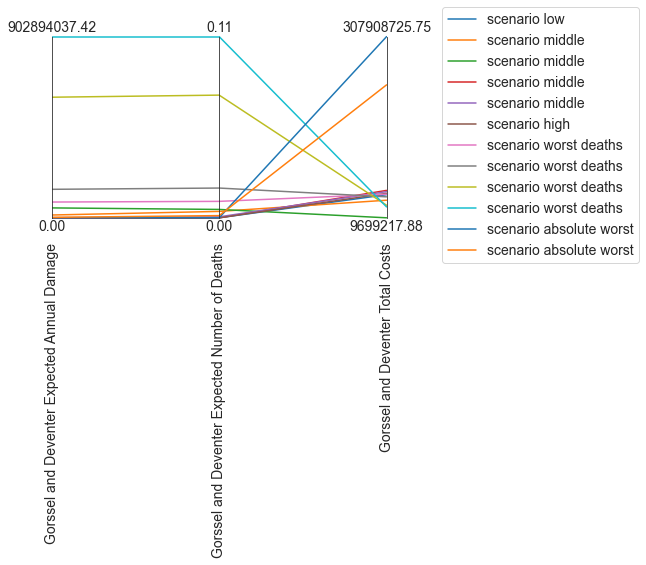

In [8]:
colors = iter(sns.color_palette(n_colors = 12))
limits = parcoords.get_limits(policies.iloc[:, 13:16])

# limits.loc[0, ['inertia', 'reliability']] = 1
# limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for index, row in policies.iterrows():
    color = next(colors)
    paraxes.plot(row, label=f'scenario {cases[row.scenario]}', color=color)

paraxes.legend()
plt.rcParams["figure.figsize"] = (10,10)

plt.show()


# Reevaluate under deep uncertainty

## Reading
Read in the results from the reevaluate under deep uncertainty


In [9]:
n_scenarios = 1000

In [10]:
du_experiments, du_outcomes = load_results("simulation/optimisation/du_scen_" + str(n_scenarios) + "_" + ACTORNAME + ".tar.gz")

### Keep only the DU experiments and outcomes that are in POLICIES
This way only the selected policies (and the respective scenarios) are brought into the rest of the analysis.


Besides this there is also is one additional policy that snuck in, 
due to the fact that they have similar policy 
levers that are reported within the 12. This is either 
scenario worst deaths option 9  or scenario absolute worst option 4
at random the later was chosen to be removed.

In [11]:
du_outcomes_df = pd.DataFrame.from_dict(du_outcomes)
merged_du = pd.concat([du_experiments, du_outcomes_df], axis=1)

merged_du = merged_du[merged_du.policy != 'scenario absolute worst option 4']
merged_du.head(5)

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,A.0_ID flood wave shape,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,100.0,...,0.0,0.0,0.0,0.0,0,scenario best option 0,dikesnet,9.668927e+07,0.005739,8035.322101
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,28.0,...,0.0,0.0,0.0,0.0,1,scenario best option 0,dikesnet,1.231742e+08,0.007150,10312.369607
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,68.0,...,0.0,0.0,0.0,0.0,2,scenario best option 0,dikesnet,9.867210e+07,0.005395,7106.948362
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,9.0,...,0.0,0.0,0.0,0.0,3,scenario best option 0,dikesnet,6.953149e+07,0.004751,4919.693263
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,15.0,...,0.0,0.0,0.0,0.0,4,scenario best option 0,dikesnet,1.551139e+08,0.006803,11628.785964


In [12]:
#now compare the policies in merged_du to the policies in 'policies' 
policies_policy_df = policies.iloc[:, 0:13]
DU_policy_selected_df = pd.merge(policies_policy_df, merged_du, how = "inner")
DU_policy_selected_df.head(5)

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,...,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario,policy,model,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs
0,0,0,0,0,0,0,3,5,0,0,...,0.787640,2.5,2.5,4.5,0,scenario low option 0,dikesnet,8.219662e+05,0.000085,4.774552e+07
1,0,0,0,0,0,0,3,5,0,0,...,0.896312,2.5,2.5,4.5,1,scenario low option 0,dikesnet,6.785163e+06,0.000507,4.774593e+07
2,0,0,0,0,0,0,3,5,0,0,...,0.877024,2.5,2.5,2.5,2,scenario low option 0,dikesnet,1.567988e+06,0.000110,4.774554e+07
3,0,0,0,0,0,0,3,5,0,0,...,0.375721,4.5,2.5,1.5,3,scenario low option 0,dikesnet,0.000000e+00,0.000000,4.774545e+07
4,0,0,0,0,0,0,3,5,0,0,...,0.555518,2.5,1.5,3.5,4,scenario low option 0,dikesnet,3.136713e+07,0.001714,4.774773e+07


#### rewrite du_experiments and du_outcomes with the filtered version

In [13]:
du_outcomes_policy_df = DU_policy_selected_df[DU_policy_selected_df.columns[-3:]].copy()
du_experiments = DU_policy_selected_df[DU_policy_selected_df.columns[0:55]].copy()
du_outcomes = du_outcomes_policy_df.to_dict('series')

## Regret
Comparing alternatives
"With a regret view, a decision maker wants to minimize the regret of choosing incorrectly, where regret is the loss in performance. This regret could be the cost of assuming the wrong future scenario or the cost of choosing the wrong alternative. In the first case, maximum regret of an alternative is the difference between its performances in the best estimate future scenario and in the scenario where it shows the worst performance, for example, as applied by Kasprzyk et al. (2013). In the second case, the regret of an alternative in a certain future scenario is the difference between its performance and the best-performing alternative, as proposed by Savage (1951). Maximum regret of an alternative is its highest regret achieved over all future scenarios. In both regret cases, the alternative with the smallest maximum regret is the most robust."

https://link.springer.com/article/10.1007/s13595-017-0641-2

In [14]:
outcomekeys = list(du_outcomes.keys())
outcomekeys

['Gorssel and Deventer Expected Annual Damage',
 'Gorssel and Deventer Expected Number of Deaths',
 'Gorssel and Deventer Total Costs']

In [15]:
DAMAGE = outcomekeys[0]
DEATHS = outcomekeys[1]
COSTS = outcomekeys[2]

#### The Regret calculation based on assignments

In [16]:
overall_scores = {}
regret = []
for scenario in du_experiments.scenario.unique():
    logical = du_experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in du_outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = du_experiments[du_experiments.scenario==scenario]
    best = temp_results.min() #we are minimizing
    scenario_regret = temp_results - best
    scenario_regret['policy'] = temp_experiments.policy.values
    regret.append(scenario_regret)

In [17]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max().dropna() #dropna to remove some artifacts that were left

In [18]:
maxregret

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs
policy,,,
scenario absolute worst option 10,1.732519e+08,0.061058,2.188092e+08
scenario absolute worst option 7,1.453990e+08,0.006943,2.982154e+08
scenario high option 0,6.535865e+08,0.108780,4.027367e+07
scenario low option 0,8.807882e+08,0.114561,3.805669e+07
scenario middle option 1,8.807882e+08,0.114561,4.513200e+07
scenario middle option 12,1.516642e+09,0.404481,2.895181e+07
scenario middle option 3,1.516642e+09,0.170558,0.000000e+00
scenario middle option 9,8.807882e+08,0.978414,4.309040e+07
scenario worst deaths option 13,4.882732e+08,0.063501,3.450904e+07


#### renaming policies for legend
rename policy names to things that will stick and we'll remember
In the order that they are above, replace with 
O_0, O_1, O_2, O_3, O_4, O_5, O_5, O_7, O_8, O_9, O_10, O_11,

At the same time create a dictionary for the colours that is linked to the policy name, so that for the following graphs, the same policies have the same colour.

In [19]:
#naming and colour block

old_names = maxregret.index.values.tolist()
new_names = []
dict_naming = {}

for i in range(len(maxregret)):
    name = "O_" + str(i)
    #print(name)
    new_names.append(name)
dict_naming = {old_names[i]: new_names[i] for i in range(len(old_names))}
#dict_naming    

#Dictionary for the coloursss
color_list =  sns.color_palette('Spectral',len(old_names))
dict_colours = {old_names[i]: color_list[i] for i in range(len(old_names))}


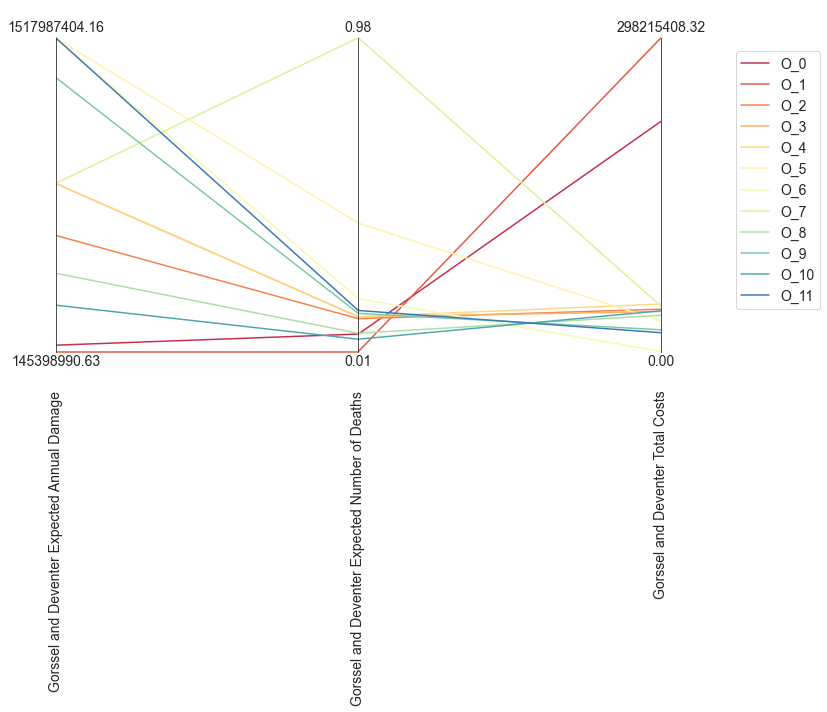

In [20]:
from matplotlib import cm

limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)

for index, row in maxregret.iterrows():
    paraxes.plot(row, color=dict_colours[index], label=dict_naming[index])
    
paraxes.legend()
plt.savefig("../../report/figures/results/regret_figure"+ "_" + ACTORNAME+ ".png", bbox_inches="tight")
plt.show()

## Satisficing
Performance threshold
"seeks a decision alternative that meets his or her performance requirements over the range of plausible future scenarios. "

For the satisficing analysis, the domain criterion metric from the assignments and as discussed in the paper: [(Bartholomew, Kwakkel 2020)](https://repository.tudelft.nl/islandora/object/uuid%3A17668d72-4ae4-47a4-9905-ebb0e1e75128). Another option that we explored was looking over the policies and seeing if there are any policies that are within all three thresholds. 

The threshold values are found within funs_project.py and sources can be found within the acompanying report.

In [21]:
satisfycing_df = policies.copy()
satisfycing_df.drop_duplicates(inplace=True)
#satisfycing_df

In [22]:
belowtresh_df = satisfycing_df.loc[(satisfycing_df['Gorssel and Deventer Expected Annual Damage'] < fp.thresholds_overijssel['Gorssel and Deventer Expected Annual Damage']) & \
                    (satisfycing_df['Gorssel and Deventer Expected Number of Deaths'] < fp.thresholds_overijssel['Gorssel and Deventer Expected Number of Deaths']) & \
                    (satisfycing_df['Gorssel and Deventer Total Costs'] < fp.thresholds_overijssel['Gorssel and Deventer Total Costs']),:].copy()
belowtresh_df.sort_index(inplace=True, ascending = False)
belowtresh_df

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,scenario


From the 12 selected policies there is not one policy that falls completly within all the thresholds for Overijssel. 

### Domain-criterion analysis

In [23]:
limits_df = belowtresh_df.iloc[:, -4:-1]
colors = iter(sns.color_palette())
limits = parcoords.get_limits(limits_df)

In [24]:
overall_scores = {}
for policy in du_experiments.policy.unique():
    logical = du_experiments.policy == policy
    scores = {}
    for k, v in du_outcomes.items():
        try:
            n = np.sum(v[logical]<=fp.thresholds_overijssel[k])#check if it is below thresholds
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

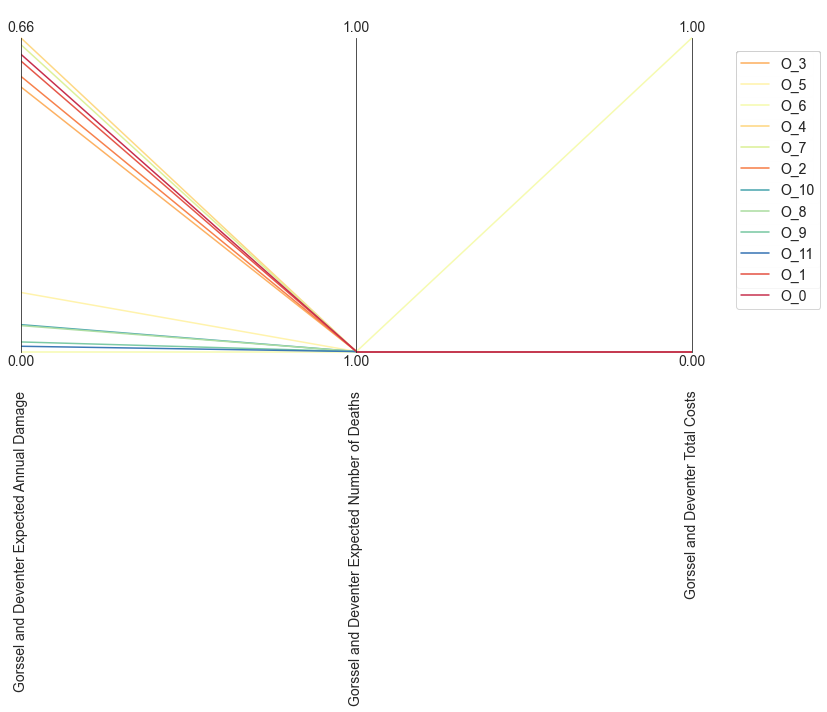

In [25]:
from matplotlib import cm

limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)

for index, row in overall_scores.iterrows():

    paraxes.plot(row, color=dict_colours[index], label=dict_naming[index])
    
    paraxes.legend()
plt.savefig("../../report/figures/results/domain_criterion"+ "_" + ACTORNAME+ ".png", bbox_inches="tight")
plt.show()

In [26]:
overall_scores

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs
scenario low option 0,0.554,1.0,0.0
scenario middle option 12,0.126,1.0,0.0
scenario middle option 3,0.003,1.0,1.0
scenario middle option 1,0.656,1.0,0.0
scenario middle option 9,0.642,1.0,0.0
scenario high option 0,0.576,1.0,0.0
scenario worst deaths option 3,0.059,1.0,0.0
scenario worst deaths option 13,0.057,1.0,0.0
scenario worst deaths option 15,0.023,1.0,0.0
scenario worst deaths option 9,0.014,1.0,0.0


## Scoring policies
This part combines the results from both robustness measures to score the policies and select the most robust 5 policies. The regret results are normalised first to make it possible to get a 'good' average. This will be done by first taking the average of the two metrics and than sorting first by the domain-criterion and then by regret.

### Normalise the regret and take the average to score the policies


In [27]:
from sklearn import preprocessing

In [28]:
#Normalize the regret results
regret_scores = maxregret.copy()
regret_average = regret_scores.apply(lambda x: x/x.max(), axis=0)

In [29]:
#Get the average for each policy
regret_average['average regret'] = regret_average.mean(numeric_only=True, axis=1)
regret_average.sort_values(by='average regret', ascending = False, inplace = True) #Lower = better
regret_average

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,average regret
policy,,,,
scenario middle option 9,0.580234,1.000000,0.144494,0.574909
scenario middle option 12,0.999114,0.413405,0.097084,0.503201
scenario worst deaths option 9,1.000000,0.137075,0.060024,0.399033
scenario middle option 3,0.999114,0.174321,0.000000,0.391145
scenario absolute worst option 7,0.095784,0.007096,1.000000,0.367627
scenario worst deaths option 15,0.885726,0.127869,0.069324,0.360973
scenario absolute worst option 10,0.114133,0.062405,0.733729,0.303422
scenario middle option 1,0.580234,0.117089,0.151340,0.282888
scenario low option 0,0.580234,0.117089,0.127615,0.274979


###  Use the satisficing / domain criterion and take their average to score the policies


In [30]:
#Get the average for each policy
satisficing_average = overall_scores.copy()
satisficing_average['average satisficing'] = satisficing_average.mean(numeric_only=True, axis=1)
satisficing_average.sort_values(by='average satisficing', ascending = True, inplace = True) #higher = better
satisficing_average

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,average satisficing
scenario worst deaths option 9,0.014,1.0,0.0,0.338000
scenario worst deaths option 15,0.023,1.0,0.0,0.341000
scenario worst deaths option 13,0.057,1.0,0.0,0.352333
scenario worst deaths option 3,0.059,1.0,0.0,0.353000
scenario middle option 12,0.126,1.0,0.0,0.375333
scenario low option 0,0.554,1.0,0.0,0.518000
scenario high option 0,0.576,1.0,0.0,0.525333
scenario absolute worst option 7,0.608,1.0,0.0,0.536000
scenario absolute worst option 10,0.622,1.0,0.0,0.540667
scenario middle option 9,0.642,1.0,0.0,0.547333


### Add them together  

In [31]:
merged_df = pd.concat([satisficing_average, regret_average], join="inner", axis = 1)


In [32]:
merged_df.sort_values(by='average satisficing', inplace = True, ascending = True)
merged_df.sort_values(by='average regret', inplace = True, ascending = False)
merged_df

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,average satisficing,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,average regret
scenario middle option 9,0.642,1.0,0.0,0.547333,0.580234,1.000000,0.144494,0.574909
scenario middle option 12,0.126,1.0,0.0,0.375333,0.999114,0.413405,0.097084,0.503201
scenario worst deaths option 9,0.014,1.0,0.0,0.338000,1.000000,0.137075,0.060024,0.399033
scenario middle option 3,0.003,1.0,1.0,0.667667,0.999114,0.174321,0.000000,0.391145
scenario absolute worst option 7,0.608,1.0,0.0,0.536000,0.095784,0.007096,1.000000,0.367627
scenario worst deaths option 15,0.023,1.0,0.0,0.341000,0.885726,0.127869,0.069324,0.360973
scenario absolute worst option 10,0.622,1.0,0.0,0.540667,0.114133,0.062405,0.733729,0.303422
scenario middle option 1,0.656,1.0,0.0,0.552000,0.580234,0.117089,0.151340,0.282888
scenario low option 0,0.554,1.0,0.0,0.518000,0.580234,0.117089,0.127615,0.274979
scenario high option 0,0.576,1.0,0.0,0.525333,0.430561,0.111179,0.135049,0.225597


In [33]:
#take te most robust policies and put them into a df.
robust_policies = merged_df.tail(5)
robust_policies

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,average satisficing,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,average regret
scenario middle option 1,0.656,1.0,0.0,0.552000,0.580234,0.117089,0.151340,0.282888
scenario low option 0,0.554,1.0,0.0,0.518000,0.580234,0.117089,0.127615,0.274979
scenario high option 0,0.576,1.0,0.0,0.525333,0.430561,0.111179,0.135049,0.225597
scenario worst deaths option 13,0.057,1.0,0.0,0.352333,0.321658,0.064902,0.115718,0.167426
scenario worst deaths option 3,0.059,1.0,0.0,0.353000,0.229514,0.046098,0.130038,0.135216


The policies above show that there often is a trade-off between satisficing and regret. 

## Tying it back to the policy levers.

In [34]:
#now to return to an original list of policies with this
policy_names = robust_policies.index.values.tolist()

In [35]:
temp_results = DU_policy_selected_df[DU_policy_selected_df['policy'].isin(policy_names)]

In [36]:
lever_names = policies_policy_df.columns.values.tolist()


In [37]:
robust_policies_results = temp_results[lever_names].drop_duplicates()

In [38]:
robust_policies_results

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,3,5,0,0,5,0,0
3000,0,0,0,0,0,0,3,9,0,0,5,0,0
5000,0,0,0,0,0,0,2,4,0,0,6,0,0
6000,0,0,0,0,0,0,3,0,0,0,8,0,0
7000,0,0,0,0,0,0,3,0,0,0,7,0,0


In [39]:
robust_policies_results.to_csv('simulation/selected/selected_policies_' + ACTORNAME + '.csv')

In [40]:
lever_names.append('policy')
robust_policies_results_names = temp_results[lever_names].drop_duplicates()

robust_policies_results_names

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,policy
0,0,0,0,0,0,0,3,5,0,0,5,0,0,scenario low option 0
3000,0,0,0,0,0,0,3,9,0,0,5,0,0,scenario middle option 1
5000,0,0,0,0,0,0,2,4,0,0,6,0,0,scenario high option 0
6000,0,0,0,0,0,0,3,0,0,0,8,0,0,scenario worst deaths option 3
7000,0,0,0,0,0,0,3,0,0,0,7,0,0,scenario worst deaths option 13


In [41]:
robust_policies_results_names.set_index('policy', inplace = True)



In [42]:
robust_policies_results_names

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
policy,,,,,,,,,,,,,
scenario low option 0,0,0,0,0,0,0,3,5,0,0,5,0,0
scenario middle option 1,0,0,0,0,0,0,3,9,0,0,5,0,0
scenario high option 0,0,0,0,0,0,0,2,4,0,0,6,0,0
scenario worst deaths option 3,0,0,0,0,0,0,3,0,0,0,8,0,0
scenario worst deaths option 13,0,0,0,0,0,0,3,0,0,0,7,0,0


In [43]:
robust_policies_results_names["new_policy_name"] = np.nan
for index, row in robust_policies_results_names.iterrows():
    robust_policies_results_names.at[index, "new_policy_name"] = dict_naming[index]
robust_policies_results_names.to_csv('simulation/selected/selected_policies_NAMES_' + ACTORNAME + '.csv')
robust_policies_results_names

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,new_policy_name
policy,,,,,,,,,,,,,,
scenario low option 0,0,0,0,0,0,0,3,5,0,0,5,0,0,O_3
scenario middle option 1,0,0,0,0,0,0,3,9,0,0,5,0,0,O_4
scenario high option 0,0,0,0,0,0,0,2,4,0,0,6,0,0,O_2
scenario worst deaths option 3,0,0,0,0,0,0,3,0,0,0,8,0,0,O_10
scenario worst deaths option 13,0,0,0,0,0,0,3,0,0,0,7,0,0,O_8


# Plot for Overijssel both robusness things in one
This was a atempt at merging the two parax, figures in one figure (below eachother) so save space in the report and make it easier to compare. Unfortunatly, the paraxes figures does not easily cooperate with matplotlib combinging, so an attempt was made to combine them on a lower level. 


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_text', '_adjustable', '_agg_filter', '_alias_map', '_alpha', '_anchor', '_animated', '_aspect', '_autoscaleXon', '_autoscaleYon', '_autotitlepos', '_axes', '_axes_class', '_axes_locator', '_axisbelow', '_box_aspect', '_clipon', '_clippath', '_contains', '_convert_dx', '_current_image', '_default_contains', '_facecolor', '_fill_between_x_or_y', '_frameon', '_gci', '_gen_axes_patch', '_gen_axes_spines', '_get_axis_list', '_get_axis_map', '_get_clipping_extent_bbox', '_get_lines', '_get_patches_for_fill', '_get_view', '_gid', '_gridOn', '_in_layout', '_init_axis', '_label', '_layoutbox', '_left_title', '_make_twi

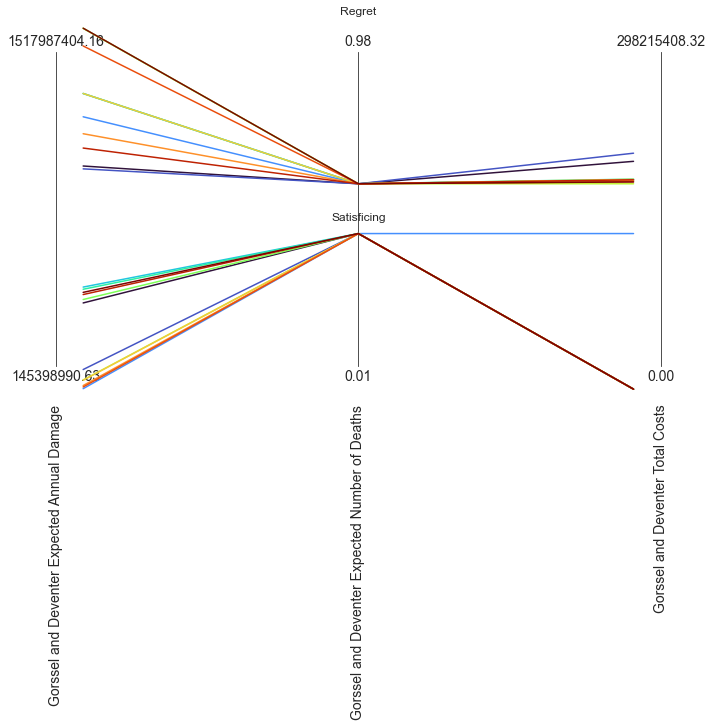

In [44]:
# fig, axs = plt.subplots(2)
# fig.suptitle('Robustness results Overijssel')



#regret plotting
limits = parcoords.get_limits(maxregret)
parax = parcoords.ParallelAxes(limits)

axs = parax.fig.subplots(2)

print(dir(axs[0]))

axs[0].set_axis_off()
axs[1].set_axis_off()

cmap = cm.get_cmap('turbo', maxregret.shape[0])
i=0
for index, row in maxregret.iterrows():
    axs[0].plot(row, color=cmap.colors[i], label=dict_naming[index])
    i+=1


axs[0].set_title("Regret")
    
axs[1].set_title("Satisficing")
    
#print(dir(axs[0]))
cmap = cm.get_cmap('turbo', overall_scores.shape[0])
i=0
for index, row in overall_scores.iterrows():
    axs[1].plot(row, color=cmap.colors[i], label=dict_naming[index])
    i+=1
    